# Table of Contents

* [Bank Customer Churn Modelling](#modelling)
  * [Understanding the dataset](#understanding)
  * [Visualization](#visualization)
  * [Correlation](#correlation)
* [Transformation](#transformation)
  * [Log Balance](#log-balance)
  * [One-Hot Encoding](#one-hot)
* [Principal Component Analysis (optional)](#pca)
* [Partitioning](#partitioning)
* [Prediction](#prediction)
  * [Logistic Regression](#logistic)
    * [scikit](#scikit)
    * [keras](#keras)
    * [log](#log)
  * [k-NN](#knn)
  * [Decision Tree Classifier](#decision)
  * [Ensemble Methods](#ensemble)
  * [Neural Network (optional)](#nn)
    * [FCNN](#fcnn)
    * [FCNN with SMOTE](#smote)
* [Model Selection](#selection)

# Bank Customer Churn Modelling <a class="anchor" id="modelling"></a>

Predicting customer churn using this [kaggle dataset](https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, StandardScaler
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTE

import scikitplot as skplt

from numpy.random import seed
seed(12345)
tf.random.set_seed(12345)

%matplotlib inline

## Understanding the dataset <a class="anchor" id="understanding"></a>

In [2]:
bank_data = pd.read_csv("churn_modelling.csv");
display(bank_data.shape) # rows & columns

(10000, 14)

In [3]:
bank_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
bank_data.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

There are 10000 records. Both RowNumber and CustomerId are unique throughout the entire set, therefore we will remove them. Surname also should not have any information (unless we are profiling by name, which we will not).

In [5]:
display(bank_data.isnull().sum()) # display missing values

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [6]:
display(bank_data.nunique()) # display unique values

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

There are 10000 rows and no missing values. CustomerID and RowNumber are both unique and can be removed. Surname will also be removed.

In [7]:
bank_data.drop(columns=['RowNumber','CustomerId','Surname'], inplace=True);

## Visualization <a class="anchor" id="visualization"></a>

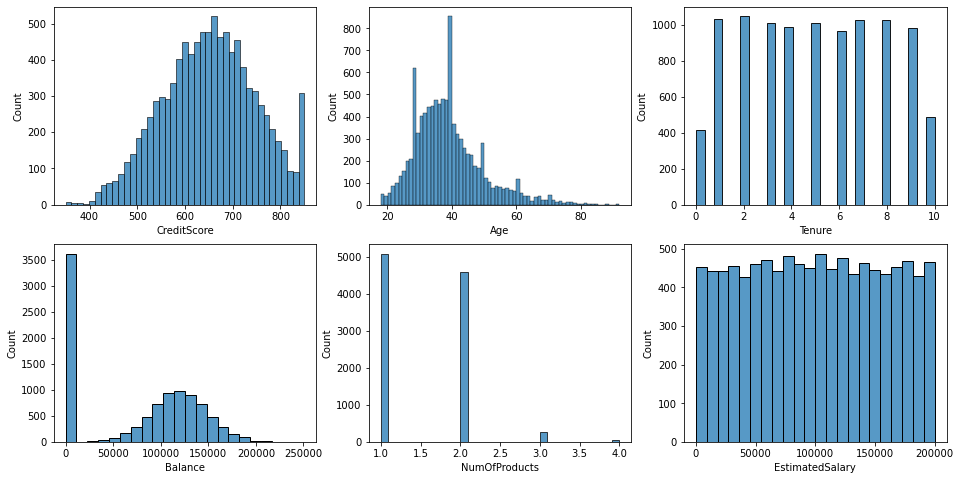

In [8]:
# Display all numeric values
fig, axes = plt.subplots(2, 3, figsize=(16, 8));
sns.histplot(ax=axes[0, 0], data=bank_data["CreditScore"]);
sns.histplot(ax=axes[0, 1], data=bank_data["Age"]);
sns.histplot(ax=axes[0, 2], data=bank_data["Tenure"]);
sns.histplot(ax=axes[1, 0], data=bank_data["Balance"]);
sns.histplot(ax=axes[1, 1], data=bank_data["NumOfProducts"]);
sns.histplot(ax=axes[1, 2], data=bank_data["EstimatedSalary"]);

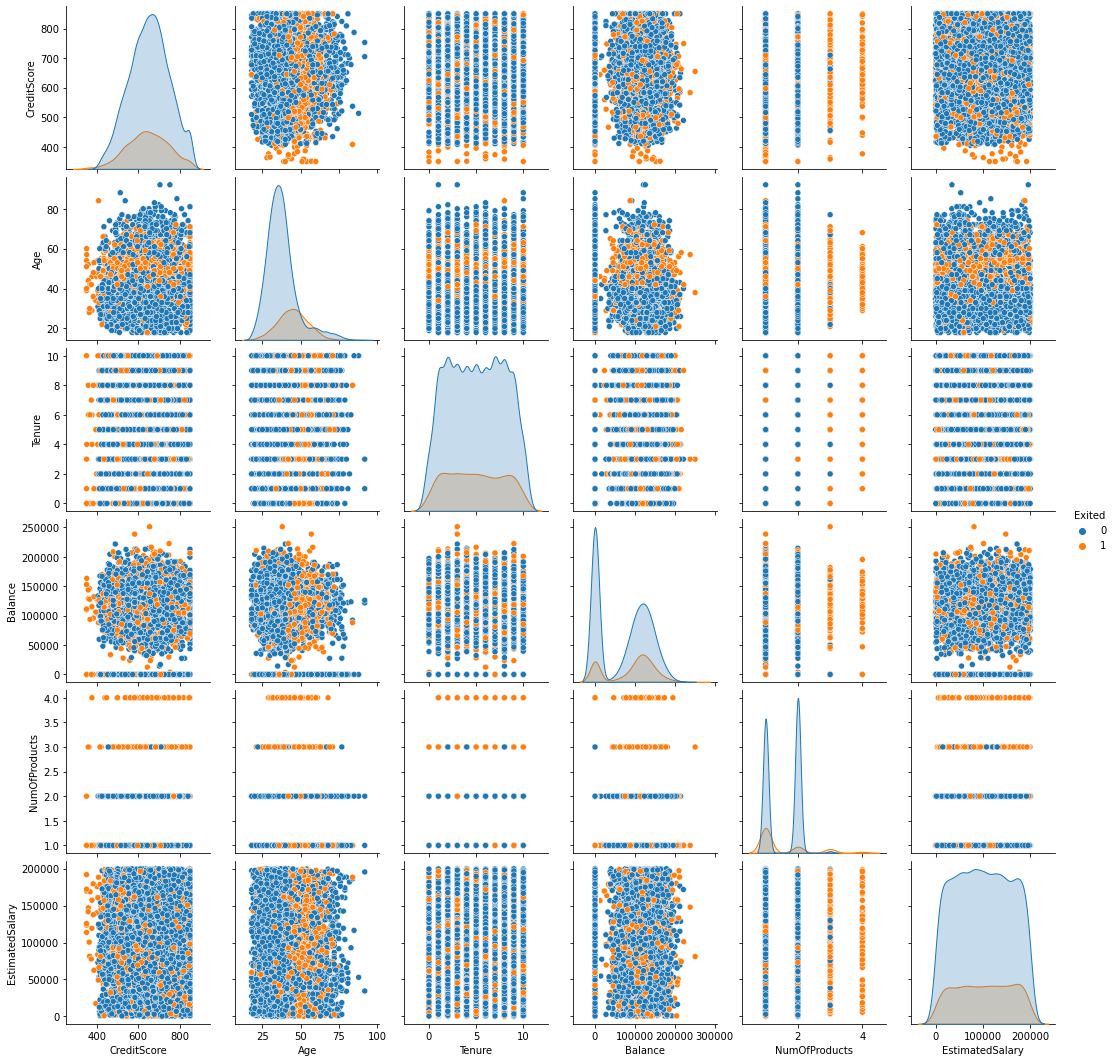

In [9]:
# Plot all numerical variables versus each other
bd_numeric = bank_data[["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary", "Exited"]];
sns.pairplot(bd_numeric, hue="Exited");

Observations:

* Balance is bimodal, might need to try a log transformation.
* People with more products tend to exit
* Older people tend to exit

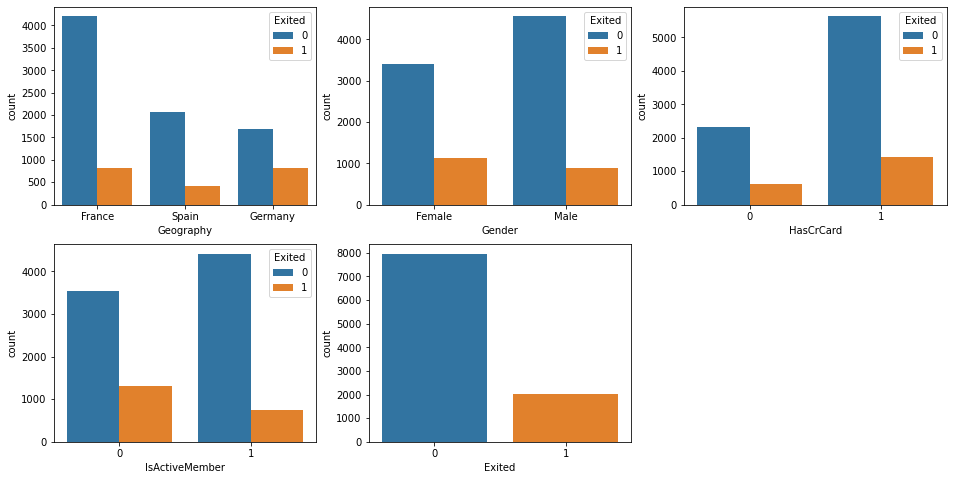

In [10]:
# Plot the categorical variables
fig, axes = plt.subplots(2, 3, figsize=(16, 8));
sns.countplot(ax=axes[0, 0], data=bank_data, x="Geography", hue="Exited");
sns.countplot(ax=axes[0, 1], data=bank_data, x="Gender", hue="Exited");
sns.countplot(ax=axes[0, 2], data=bank_data, x="HasCrCard", hue="Exited");
sns.countplot(ax=axes[1, 0], data=bank_data, x="IsActiveMember", hue="Exited");
sns.countplot(ax=axes[1, 1], data=bank_data, x="Exited");
fig.delaxes(axes[1][2]);

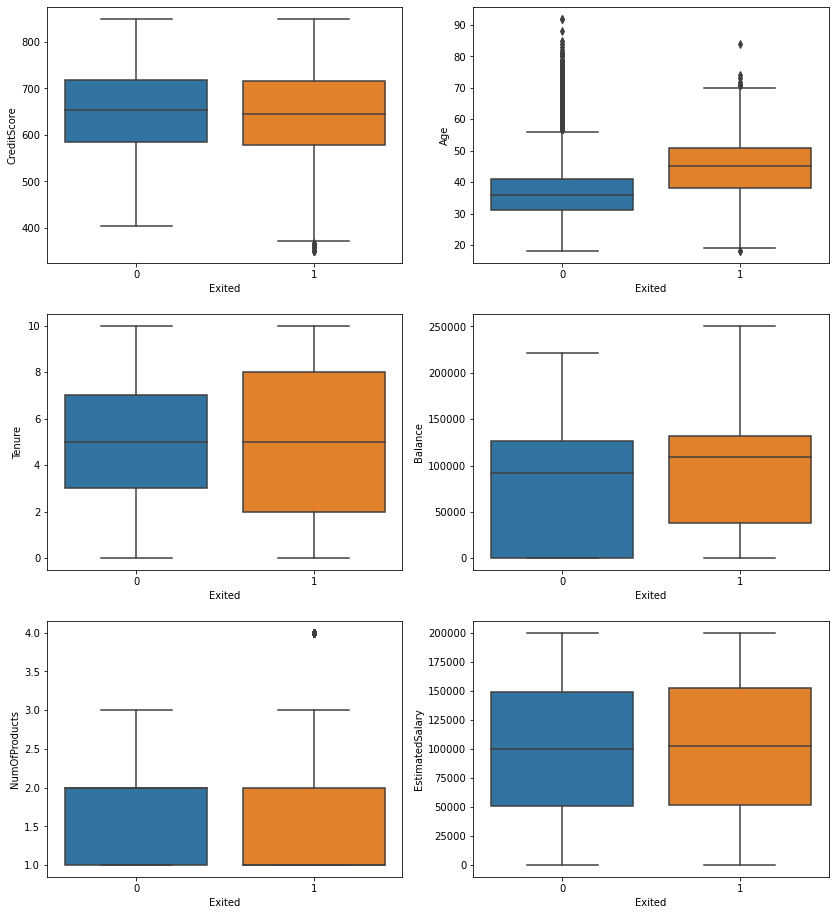

In [11]:
fig, axes = plt.subplots(3, 2, figsize=(14, 16));
sns.boxplot(ax=axes[0, 0], data=bank_data, x="Exited", y="CreditScore");
sns.boxplot(ax=axes[0, 1], data=bank_data, x="Exited", y="Age");
sns.boxplot(ax=axes[1, 0], data=bank_data, x="Exited", y="Tenure");
sns.boxplot(ax=axes[1, 1], data=bank_data, x="Exited", y="Balance");
sns.boxplot(ax=axes[2, 0], data=bank_data, x="Exited", y="NumOfProducts");
sns.boxplot(ax=axes[2, 1], data=bank_data, x="Exited", y="EstimatedSalary");

In [12]:
display(pd.crosstab(bank_data["Exited"], bank_data["Geography"], margins=True, normalize=False))
display(pd.crosstab(bank_data["Exited"], bank_data["Geography"], margins=True, normalize=True))

Geography,France,Germany,Spain,All
Exited,,,,
0,4204,1695,2064,7963
1,810,814,413,2037
All,5014,2509,2477,10000


Geography,France,Germany,Spain,All
Exited,,,,
0,0.4204,0.1695,0.2064,0.7963
1,0.0810,0.0814,0.0413,0.2037
All,0.5014,0.2509,0.2477,1.0000


In [13]:
display(pd.crosstab(bank_data["Exited"], bank_data["Gender"], margins=True, normalize=False))
display(pd.crosstab(bank_data["Exited"], bank_data["Gender"], margins=True, normalize=True))

Gender,Female,Male,All
Exited,,,
0,3404,4559,7963
1,1139,898,2037
All,4543,5457,10000


Gender,Female,Male,All
Exited,,,
0,0.3404,0.4559,0.7963
1,0.1139,0.0898,0.2037
All,0.4543,0.5457,1.0000


In [14]:
display(pd.crosstab(bank_data["Exited"], bank_data["HasCrCard"], margins=True, normalize=False))
display(pd.crosstab(bank_data["Exited"], bank_data["HasCrCard"], margins=True, normalize=True))

HasCrCard,0,1,All
Exited,,,
0,2332,5631,7963
1,613,1424,2037
All,2945,7055,10000


HasCrCard,0,1,All
Exited,,,
0,0.2332,0.5631,0.7963
1,0.0613,0.1424,0.2037
All,0.2945,0.7055,1.0000


In [15]:
display(pd.crosstab(bank_data["Exited"], bank_data["IsActiveMember"], margins=True, normalize=False))
display(pd.crosstab(bank_data["Exited"], bank_data["IsActiveMember"], margins=True, normalize=True))

IsActiveMember,0,1,All
Exited,,,
0,3547,4416,7963
1,1302,735,2037
All,4849,5151,10000


IsActiveMember,0,1,All
Exited,,,
0,0.3547,0.4416,0.7963
1,0.1302,0.0735,0.2037
All,0.4849,0.5151,1.0000


## Correlation <a class="anchor" id="correlation"></a>

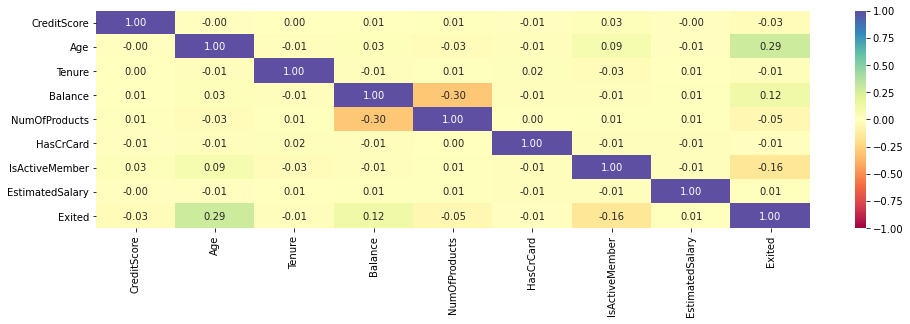

In [16]:
plt.figure(figsize=(16,4));
sns.heatmap(bank_data.corr(), annot=True, fmt=".2f", vmin=-1.0, vmax=1, cmap="Spectral");

# Transformation <a class="anchor" id="transformation"></a>

In [17]:
bank_data_transformed = bank_data;

## Log_Balance <a class="anchor" id="log-balance"></a>
Need to change all 0 balances to 1. This will still be valid for all of the data.

In [18]:
print("         Balance < 0: ", bank_data_transformed[bank_data_transformed["Balance"].lt(0)].shape[0])
print("         Balance = 0: ", bank_data_transformed[bank_data_transformed["Balance"].eq(0)].shape[0])
print("1 <= Balance <= 1000: ", bank_data_transformed[bank_data_transformed["Balance"].between(1, 1000)].shape[0])

         Balance < 0:  0
         Balance = 0:  3617
1 <= Balance <= 1000:  0


In [19]:
bank_data_transformed["Balance_1"] = bank_data_transformed["Balance"].replace(0, 1);
print("         Balance_1 = 0: ", bank_data_transformed[bank_data_transformed["Balance_1"].eq(0)].shape[0])
print("         Balance_1 = 1: ", bank_data_transformed[bank_data_transformed["Balance_1"].eq(1)].shape[0])

         Balance_1 = 0:  0
         Balance_1 = 1:  3617


In [20]:
bank_data_transformed["Log10_Balance_1"] = np.log10(bank_data_transformed["Balance_1"]);

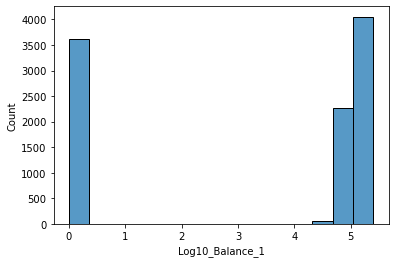

In [21]:
sns.histplot(data=bank_data_transformed["Log10_Balance_1"]);

## One-Hot Encoding <a class="anchor" id="one-hot"></a>

In [22]:
bank_data_transformed = pd.concat([bank_data_transformed,pd.get_dummies(bank_data_transformed['Geography'], prefix='Geography')],axis=1)
bank_data_transformed = pd.concat([bank_data_transformed,pd.get_dummies(bank_data_transformed['Gender'], prefix='Gender')],axis=1)
bank_data_transformed.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Balance_1,Log10_Balance_1,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1.00,0.000000,1,0,0,1,0
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,83807.86,4.923285,0,0,1,1,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,159660.80,5.203198,1,0,0,1,0
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,1.00,0.000000,1,0,0,1,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,125510.82,5.098681,0,0,1,1,0


# Principal Component Analysis (Optional) <a class="anchor" id="pca"></a>

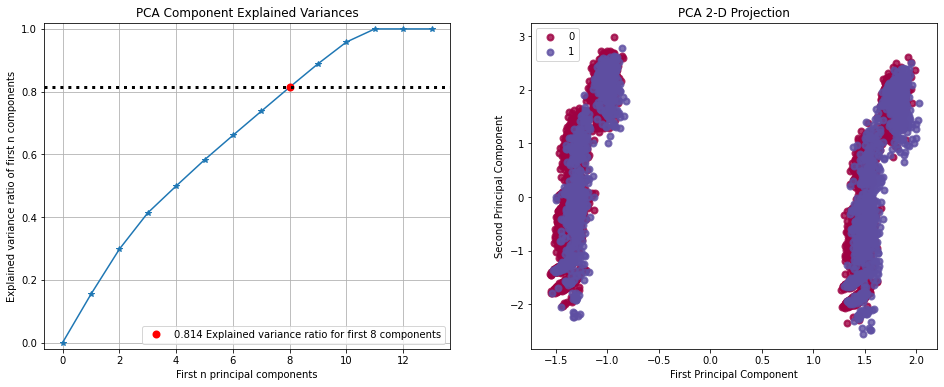

In [23]:
standard_scaler = StandardScaler();
scaled_columns = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Geography_France", "Geography_Germany", "Geography_Spain", "Gender_Male", "Gender_Female"]
scaled_x = pd.DataFrame(standard_scaler.fit_transform(bank_data_transformed[scaled_columns]), columns=scaled_columns)
scaled_y = bank_data_transformed["Exited"]

pca = PCA()
pca.fit(scaled_x)

fig, axes = plt.subplots(1, 2, figsize=(16, 6));

skplt.decomposition.plot_pca_component_variance(clf=pca, ax=axes[0]);
skplt.decomposition.plot_pca_2d_projection(pca, scaled_x, scaled_y, ax=axes[1]);

# Partitioning (60:20:20) <a class="anchor" id="partitioning"></a>

In [24]:
random_seed=12345
bdt_train = bank_data_transformed.sample(frac=0.6, random_state=random_seed) # Train 60%
bdt_test = bank_data_transformed.drop(bdt_train.index)

bdt_validate = bdt_test.sample(frac=0.5,random_state=random_seed)   # Validate = 50% of remaining 40% ==> 20%
bdt_test = bdt_test.drop(bdt_validate.index)                        # Test = 20%

print("training set: ", len(bdt_train))
print("validation set: ", len(bdt_validate))
print("test set: ", len(bdt_test))

display(bdt_train.head());
display(bdt_validate.head());
display(bdt_test.head());

training set:  6000
validation set:  2000
test set:  2000


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Balance_1,Log10_Balance_1,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
7867,640,Spain,Female,46,3,0.00,1,1,1,156260.08,0,1.00,0.000000,0,0,1,1,0
1402,757,France,Male,29,8,130306.49,1,1,0,77469.38,0,130306.49,5.114966,1,0,0,0,1
8606,807,Spain,Male,42,5,0.00,2,1,1,74900.90,0,1.00,0.000000,0,0,1,0,1
8885,668,Spain,Male,45,4,102486.21,2,1,1,158379.25,0,102486.21,5.010665,0,0,1,0,1
6494,699,France,Male,28,7,0.00,2,1,1,22684.78,0,1.00,0.000000,1,0,0,0,1


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Balance_1,Log10_Balance_1,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
9750,708,France,Female,51,8,70754.18,1,1,1,92920.04,1,70754.18,4.849752,1,0,0,1,0
1129,669,France,Female,35,7,0.00,1,1,1,49108.23,1,1.00,0.000000,1,0,0,1,0
2762,719,Germany,Male,28,3,106070.29,2,1,1,183893.31,0,106070.29,5.025594,0,1,0,0,1
4911,407,Spain,Male,37,1,0.00,1,1,1,49161.12,1,1.00,0.000000,0,0,1,0,1
1306,823,Spain,Female,46,3,81576.75,1,1,1,28370.95,1,81576.75,4.911566,0,0,1,1,0


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Balance_1,Log10_Balance_1,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
7,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1,115046.74,5.060874,0,1,0,1,0
12,476,France,Female,34,10,0.00,2,1,0,26260.98,0,1.00,0.000000,1,0,0,1,0
17,549,Spain,Female,24,9,0.00,2,1,1,14406.41,0,1.00,0.000000,0,0,1,1,0
25,577,France,Male,25,3,0.00,2,0,1,124508.29,0,1.00,0.000000,1,0,0,0,1
27,571,France,Male,44,9,0.00,2,0,0,38433.35,0,1.00,0.000000,1,0,0,0,1


# Prediction <a class="anchor" id="prediction"></a>

In [25]:
# Predict output, confusion matrix, and ROC curve
#def create_summary(name, data, prediction, metrics, summaries):
def create_summary(name, y, y_scores, train_accuracy, val_accuracy, summaries):
    fpr, tpr, threshold = roc_curve(y.to_numpy(), y_scores[:,1])    
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = threshold[optimal_idx]

    print("[" + name + "] Optimal threshold: {:.3}".format(optimal_threshold))
    y_hat = y_scores[:,1] > optimal_threshold
    
    name = name + " (c={:.3})".format(optimal_threshold);

    cnf_matrix = confusion_matrix(y, y_hat)
    display(cnf_matrix)
    print(classification_report(y, y_hat))
    
    y_hat_0_5 = y_scores[:,1] > 0.5

    summary = pd.DataFrame([[name,
                   train_accuracy,
                   val_accuracy,
                   accuracy_score(y, y_hat_0_5),
                   f1_score(y, y_hat_0_5),
                   auc(fpr, tpr),
                   tpr,
                   fpr,
                   cnf_matrix
                  ]], 
                 columns=summary_column_names);
    summaries = summaries.append(summary, ignore_index=True);

    fig = sns.heatmap(cnf_matrix, annot=True, fmt="d", linewidths=.5, cmap="Blues");
    fig.set_title("Confusion Matrix (Exited=1)");
    fig.set_ylabel("Actual");
    fig.set_xlabel("Predicted");

    fig, axes = plt.subplots(2, 2, figsize=(16, 16));
    skplt.metrics.plot_roc(ax=axes[0][0], y_true=y, y_probas=y_scores)
    skplt.metrics.plot_ks_statistic(ax=axes[0][1], y_true=np.ravel(y), y_probas=y_scores)
    skplt.metrics.plot_cumulative_gain(ax=axes[1][0], y_true=y, y_probas=y_scores)
    skplt.metrics.plot_lift_curve(ax=axes[1][1], y_true=y, y_probas=y_scores)

    return summaries;

summary_column_names = ["method", "training_accuracy", "validation_accuracy", "test_accuracy", "f1_score", "auc", "tpr", "fpr", "cnf_matrix"]
summaries = pd.DataFrame(columns = summary_column_names)

## Logistic Regression <a class="anchor" id="logistic"></a>

In [26]:
# First I am going to scale all inputs from 0 to 1 using the min-max method
# minmax = (x_i - x_min) / (x_max - x_min)
minmax_scaler = MinMaxScaler()

lr_columns_x = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Geography_France", "Geography_Germany", "Gender_Male"]
lr_columns_y = "Exited"

lr_train_x = pd.DataFrame(minmax_scaler.fit_transform(bdt_train[lr_columns_x]), columns=lr_columns_x)
lr_train_y = bdt_train[lr_columns_y]

lr_val_x = pd.DataFrame(minmax_scaler.fit_transform(bdt_validate[lr_columns_x]), columns=lr_columns_x)
lr_val_y = bdt_validate[lr_columns_y]

lr_test_x = pd.DataFrame(minmax_scaler.fit_transform(bdt_test[lr_columns_x]), columns=lr_columns_x)
lr_test_y = bdt_test[lr_columns_y]

In [27]:
log_columns_x = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Geography_France", "Geography_Germany", "Gender_Male"]
log_columns_y = "Exited"

log_train_x = pd.DataFrame(minmax_scaler.fit_transform(bdt_train[log_columns_x]), columns=log_columns_x)
log_train_y = bdt_train[log_columns_y]

log_val_x = pd.DataFrame(minmax_scaler.fit_transform(bdt_validate[log_columns_x]), columns=log_columns_x)
log_val_y = bdt_validate[log_columns_y]

log_test_x = pd.DataFrame(minmax_scaler.fit_transform(bdt_test[log_columns_x]), columns=log_columns_x)
log_test_y = bdt_test[log_columns_y]

### Simple Logistic Regression (scikit-learn) <a class="anchor" id="scikit"></a>

In [28]:
lr_model = LogisticRegression(solver='liblinear', C=10.0, random_state=0)
lr_model.fit(lr_train_x, lr_train_y)
lr_y_scores = lr_model.predict_proba(lr_test_x);

[slr-scikit] Optimal threshold: 0.242


array([[1221,  347],
       [ 160,  272]])

              precision    recall  f1-score   support

           0       0.88      0.78      0.83      1568
           1       0.44      0.63      0.52       432

    accuracy                           0.75      2000
   macro avg       0.66      0.70      0.67      2000
weighted avg       0.79      0.75      0.76      2000



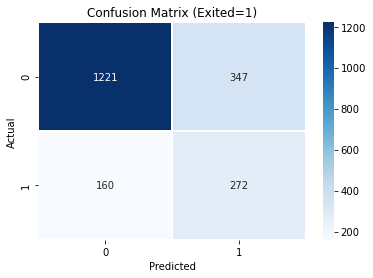

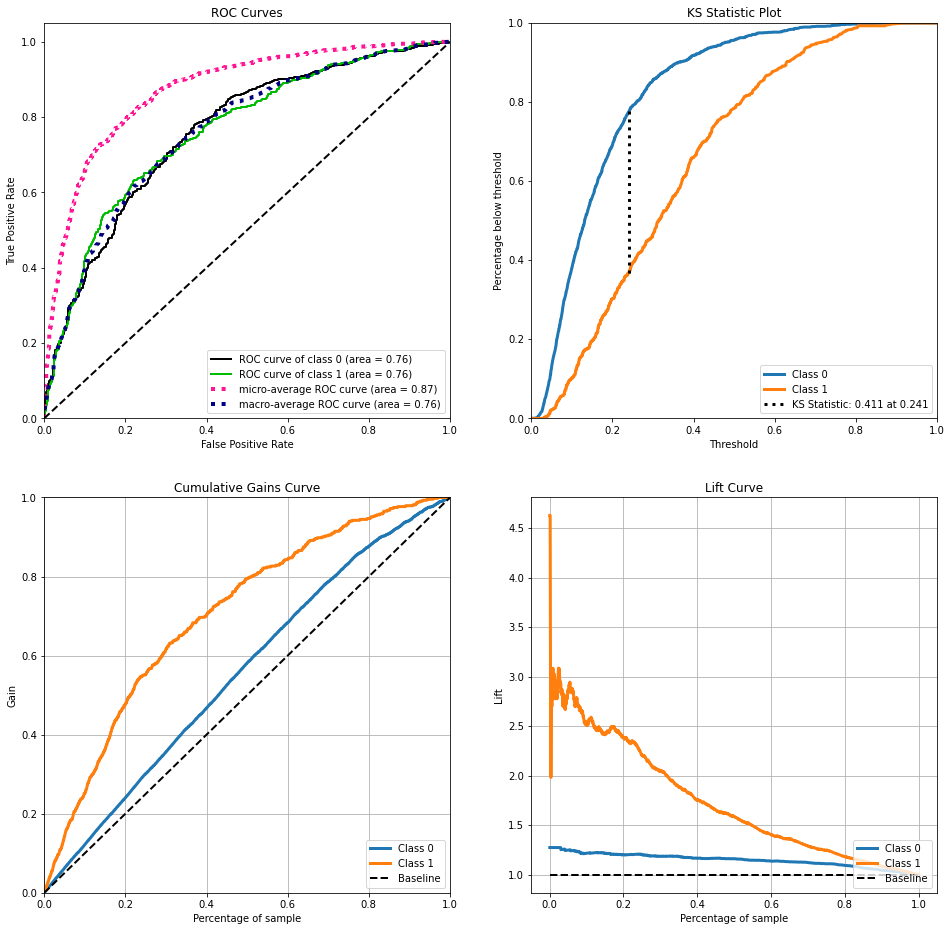

In [29]:
training_accuracy = lr_model.score(lr_train_x, lr_train_y)
validation_accuracy = lr_model.score(lr_val_x, lr_val_y)

summaries = create_summary("slr-scikit",
                           lr_test_y, 
                           lr_y_scores, 
                           training_accuracy,
                           validation_accuracy,
                           summaries);

### Simple Logistic Regression (Keras) <a class="anchor" id="keras"></a>

In [30]:
# 2-class logistic regression in Keras
lrk_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
lrk_model = Sequential()
lrk_model.add(Dense(units=1, kernel_initializer='glorot_uniform', activation='sigmoid', input_dim=lr_train_x.shape[1]))
lrk_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['binary_accuracy'])
lrk_history = lrk_model.fit(x=lr_train_x, y=lr_train_y, 
                            batch_size=64,
                            epochs=500, validation_data=(lr_val_x, lr_val_y), 
                            callbacks=[lrk_callback],
                            verbose=0);

**Note: This model takes around 30s to run**

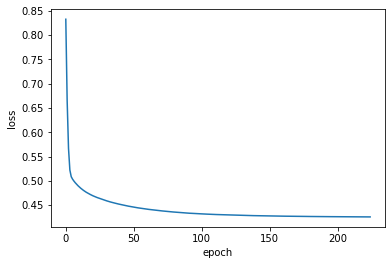

In [31]:
fig = sns.lineplot(data=lrk_history.history['loss']);
fig.set(ylabel="loss", xlabel = "epoch");

[slr-keras] Optimal threshold: 0.285


array([[1306,  262],
       [ 186,  246]])

              precision    recall  f1-score   support

           0       0.88      0.83      0.85      1568
           1       0.48      0.57      0.52       432

    accuracy                           0.78      2000
   macro avg       0.68      0.70      0.69      2000
weighted avg       0.79      0.78      0.78      2000



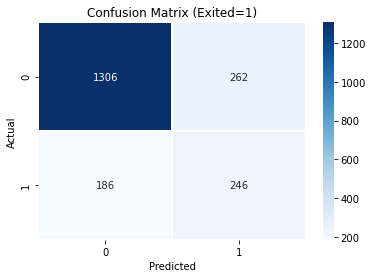

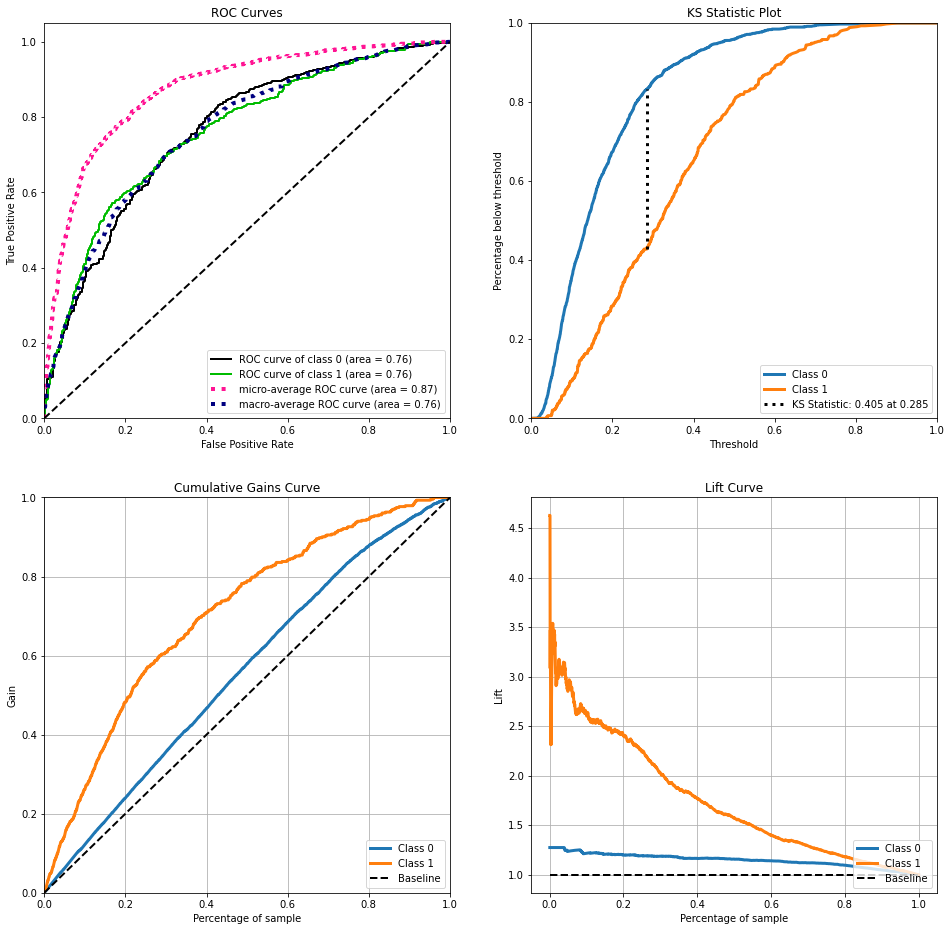

In [32]:
# Predict output, confusion matrix, and ROC curve
lrk_y_scores = lrk_model.predict(lr_test_x);
lrk_y_scores = np.append(1-lrk_y_scores, lrk_y_scores, axis=1)

training_accuracy = lrk_history.history["binary_accuracy"][-1]
validation_accuracy = lrk_history.history["val_binary_accuracy"][-1]

summaries = create_summary("slr-keras",
                           lr_test_y, 
                           lrk_y_scores, 
                           training_accuracy,
                           validation_accuracy,
                           summaries);

### Logistic Regression with Log_Balance and Regularization (Optional) <a class="anchor" id="log"></a>

In [33]:
log_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

log_parameters = {
    'epochs': 500,
    'verbose': 0
}

def create_log_model(kernel_initializer='zeros',
                     activation='sigmoid', 
                     l1_lambda=0.001,
                     l2_lambda=0.0, 
                     optimizer='sgd',
                     loss='binary_crossentropy', 
                     metrics=['accuracy']):
    model = Sequential()
    model.add(Dense(units=1,
                    kernel_initializer=kernel_initializer,
                    activation=activation,
                    input_dim=log_train_x.shape[1], 
                    kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1_lambda, l2=l2_lambda),
                    bias_initializer='zeros'))
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model;

In [34]:
# summarize results
def summarize_grid_results(grid_result):
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

# Tuning the model

# best: sgd
#log_optimizer=['rmsprop', 'sgd', 'adam']
#log_param_grid = dict(optimizer=log_optimizer)

# best: zeros
#log_kernel_initializer=['glorot_uniform', 'glorot_normal', 'random_normal', 'zeros']
#log_param_grid = dict(kernel_initializer=log_kernel_initializer)

# best: 0.001
#log_l1_lambda=[0.0, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
#log_param_grid = dict(l1_lambda=log_l1_lambda)

# best: 0.0
# log_l2_lambda=[0.0, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
# log_param_grid = dict(l2_lambda=log_l2_lambda)

# perform a Grid Search
#log_model = KerasClassifier(build_fn=create_log_model, 
#                            epochs=log_parameters['epochs'], 
#                            verbose=log_parameters['verbose'])

#log_grid = GridSearchCV(estimator=log_model, param_grid=log_param_grid, n_jobs=-1)
#log_grid_result = log_grid.fit(X=log_train_x, y=log_train_y, callbacks=[log_callback])

#summarize_grid_results(log_grid_result)

In [35]:
# uses the parameters tuned above
log_model = create_log_model()
log_history = log_model.fit(x=log_train_x, y=log_train_y,
                            epochs=log_parameters['epochs'],
                            callbacks=[log_callback],
                            validation_data=(log_val_x, log_val_y),
                            verbose=log_parameters['verbose']);

**Note: This model takes ~30s to run**

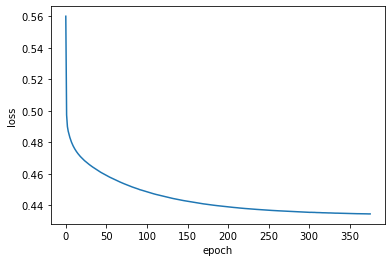

In [36]:
fig = sns.lineplot(data=log_history.history['loss']);
fig.set(ylabel="loss", xlabel = "epoch");

[slr-log-reg] Optimal threshold: 0.257


array([[1270,  298],
       [ 174,  258]])

              precision    recall  f1-score   support

           0       0.88      0.81      0.84      1568
           1       0.46      0.60      0.52       432

    accuracy                           0.76      2000
   macro avg       0.67      0.70      0.68      2000
weighted avg       0.79      0.76      0.77      2000



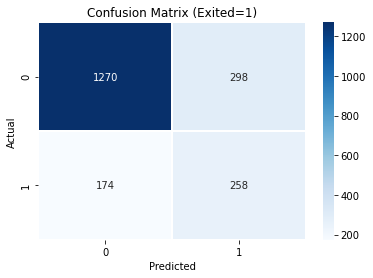

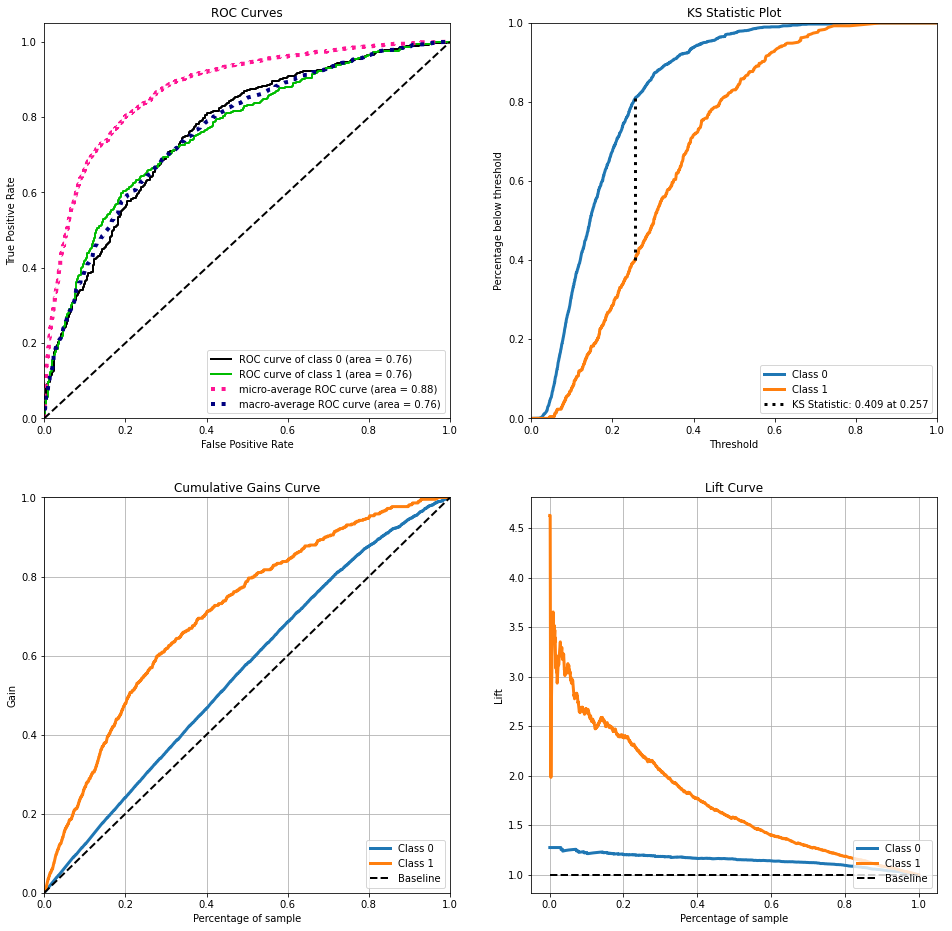

In [37]:
# Predict output, confusion matrix, and ROC curve
log_y_scores = log_model.predict(log_test_x);
log_y_scores = np.append(1-log_y_scores, log_y_scores, axis=1)

training_accuracy = log_history.history["accuracy"][-1]
validation_accuracy = log_history.history["val_accuracy"][-1]

summaries = create_summary("slr-log-reg",
                           log_test_y, 
                           log_y_scores, 
                           training_accuracy,
                           validation_accuracy,
                           summaries);

## k-NN <a class="anchor" id="knn"></a>

In [38]:
standard_scaler = StandardScaler();
knn_x_columns = ["CreditScore", "Age", "Tenure", "Log10_Balance_1", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Geography_France", "Geography_Germany", "Geography_Spain", "Gender_Male", "Gender_Female"]
knn_y_columns = ["Exited"]

knn_train_x = pd.DataFrame(standard_scaler.fit_transform(bdt_train[knn_x_columns]), columns=knn_x_columns)
knn_train_y = bdt_train[knn_y_columns]

knn_val_x = pd.DataFrame(standard_scaler.fit_transform(bdt_validate[knn_x_columns]), columns=knn_x_columns)
knn_val_y = bdt_validate[knn_y_columns]

knn_test_x = pd.DataFrame(standard_scaler.fit_transform(bdt_test[knn_x_columns]), columns=knn_x_columns)
knn_test_y = bdt_test[knn_y_columns]

In [39]:
neighbor_column_names = ["n", "validation_accuracy", "f1_score"]
neighbors = pd.DataFrame(columns = neighbor_column_names)

for n in range(1, 30):
    knn_model = KNeighborsClassifier(n_neighbors=n)
    knn_model.fit(knn_train_x, np.ravel(knn_train_y))
    y_scores = knn_model.predict_proba(knn_test_x);
    y_pred = knn_model.predict(knn_test_x);
    y_scores=y_scores[:,1]
    y_pred = y_scores > 0.5    
    neighbor = pd.DataFrame([[n,
                             knn_model.score(knn_val_x, knn_val_y),
                             f1_score(knn_test_y, y_pred)
              ]], 
             columns=neighbor_column_names);
    neighbors = neighbors.append(neighbor, ignore_index=True);

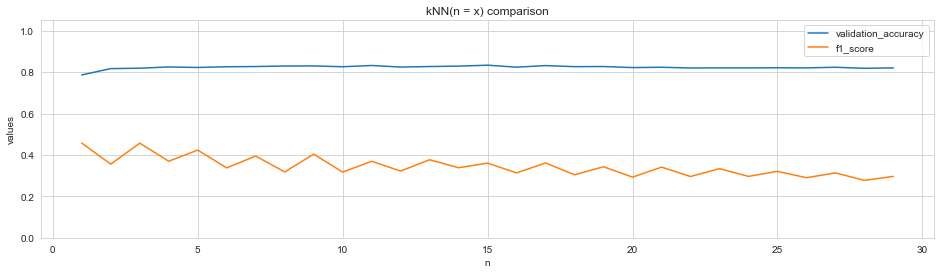

In [40]:
reshaped_neighbors = pd.melt(neighbors, id_vars="n", var_name="metric", value_name="values")
plt.figure(figsize=(16,4))
sns.set_style("whitegrid")
fig = sns.lineplot(data=reshaped_neighbors, x="n", y="values", hue="metric");
fig.set_title("kNN(n = x) comparison");
fig.legend(loc='best');
fig.set_ylim([0, 1.05]);

In [41]:
max_k_neighbor = neighbors.at[neighbors["validation_accuracy"].idxmax(), "n"]
knn_model = KNeighborsClassifier(n_neighbors=max_k_neighbor)
knn_model.fit(knn_train_x, np.ravel(knn_train_y))
knn_y_scores = knn_model.predict_proba(knn_test_x);

The best kNN fit was kNN [n=15]
[kNN [n=15]] Optimal threshold: 0.2


array([[1315,  253],
       [ 166,  266]])

              precision    recall  f1-score   support

           0       0.89      0.84      0.86      1568
           1       0.51      0.62      0.56       432

    accuracy                           0.79      2000
   macro avg       0.70      0.73      0.71      2000
weighted avg       0.81      0.79      0.80      2000



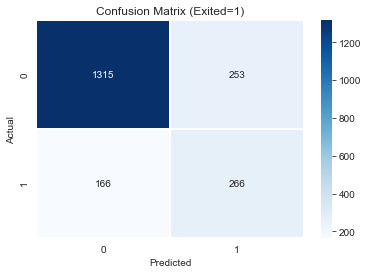

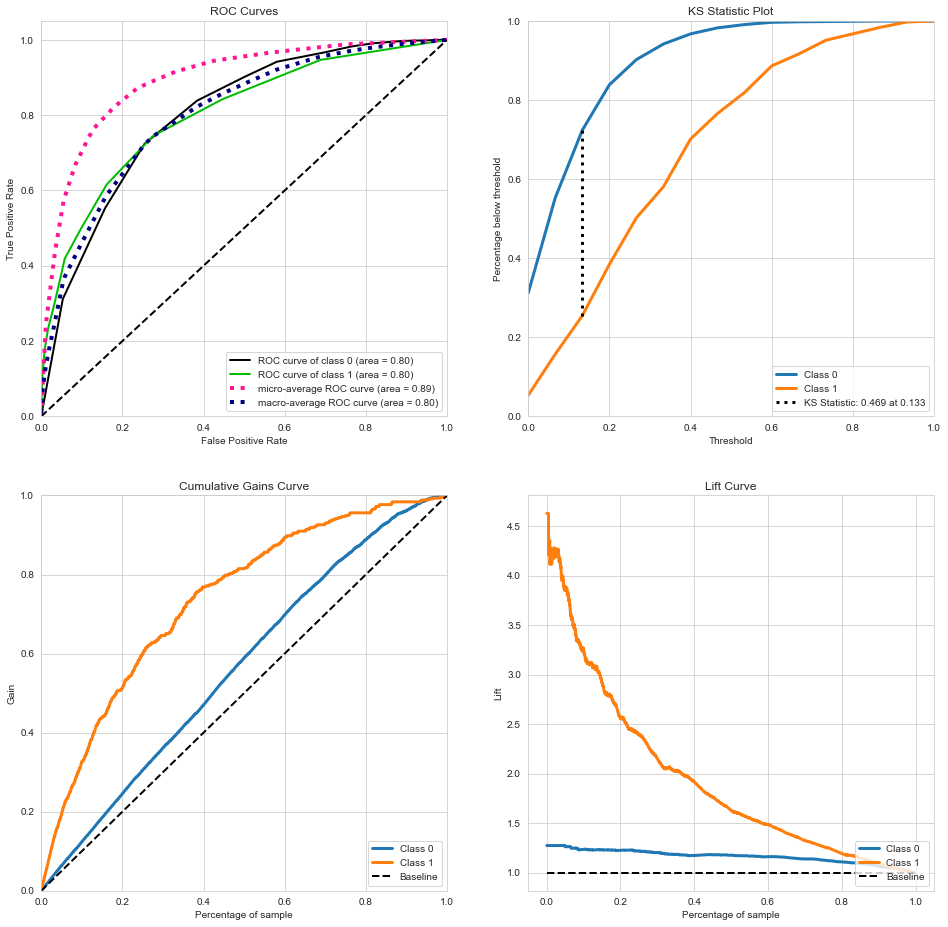

In [42]:
title = "kNN [n=" + str(max_k_neighbor) + "]"
print("The best kNN fit was " + title)

training_accuracy = knn_model.score(knn_train_x, knn_train_y)
validation_accuracy = knn_model.score(knn_val_x, knn_val_y)

summaries = create_summary(title, 
                           knn_test_y, 
                           knn_y_scores, 
                           training_accuracy,
                           validation_accuracy,
                           summaries);


## Decision Tree Classifier <a class="anchor" id="decision"></a>

In [43]:
dtc_columns_x = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Geography_France", "Geography_Germany", "Geography_Spain", "Gender_Male", "Gender_Female"]
dtc_columns_y = "Exited"

dtc_train_x = pd.DataFrame(minmax_scaler.fit_transform(bdt_train[dtc_columns_x]), columns=dtc_columns_x)
dtc_train_y = bdt_train[dtc_columns_y]

dtc_val_x = pd.DataFrame(minmax_scaler.fit_transform(bdt_validate[dtc_columns_x]), columns=dtc_columns_x)
dtc_val_y = bdt_validate[dtc_columns_y]

dtc_test_x = pd.DataFrame(minmax_scaler.fit_transform(bdt_test[dtc_columns_x]), columns=dtc_columns_x)
dtc_test_y = bdt_test[dtc_columns_y]

Number of nodes in the last tree is: 1 with ccp_alpha: 0.03865135493092198


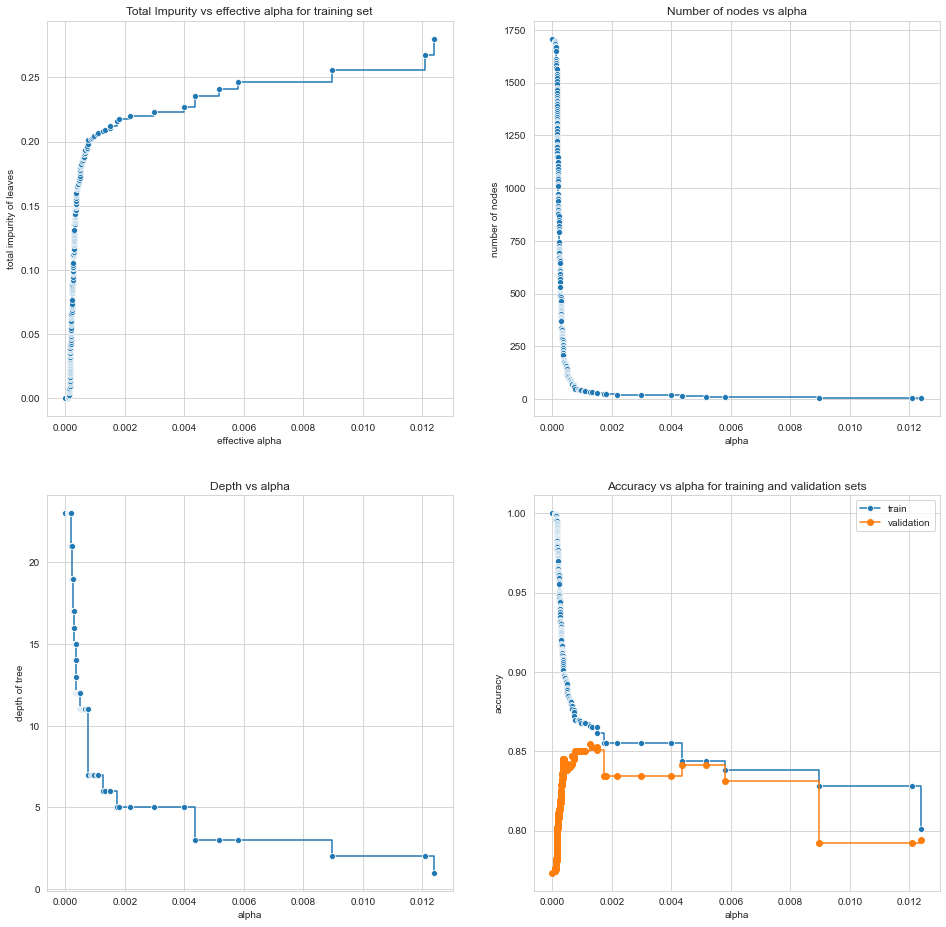

In [44]:
# Tuning a classification tree from scikit
# https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html
clf = DecisionTreeClassifier()
path = clf.cost_complexity_pruning_path(dtc_train_x, dtc_train_y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, axes = plt.subplots(2, 2, figsize=(16, 16));
fig = sns.lineplot(ax=axes[0][0], x=ccp_alphas[:-1], y=impurities[:-1], marker='o', drawstyle="steps-post")
fig.set_xlabel("effective alpha")
fig.set_ylabel("total impurity of leaves")
fig.set_title("Total Impurity vs effective alpha for training set")

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(dtc_train_x, dtc_train_y)
    clfs.append(clf)

print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]

fig=sns.lineplot(ax=axes[0][1], x=ccp_alphas, y=node_counts, marker='o', drawstyle="steps-post")
fig.set_xlabel("alpha")
fig.set_ylabel("number of nodes")
fig.set_title("Number of nodes vs alpha")

fig=sns.lineplot(ax=axes[1][0], x=ccp_alphas, y=depth, marker='o', drawstyle="steps-post")
fig.set_xlabel("alpha")
fig.set_ylabel("depth of tree")
fig.set_title("Depth vs alpha")

train_scores = [clf.score(dtc_train_x, dtc_train_y) for clf in clfs]
val_scores = [clf.score(dtc_val_x, dtc_val_y) for clf in clfs]

fig=sns.lineplot(ax=axes[1][1], x=ccp_alphas, y=train_scores, marker='o', label="train",
        drawstyle="steps-post")
fig.plot(ccp_alphas, val_scores, marker='o', label="validation",
        drawstyle="steps-post")
fig.set_xlabel("alpha")
fig.set_ylabel("accuracy")
fig.set_title("Accuracy vs alpha for training and validation sets")
fig.legend();


In [45]:
# find the highest accuracy on validation set
max_idx = np.argmax(val_scores)
max_ccp_alpha=ccp_alphas[max_idx]
max_val_accuracy=val_scores[max_idx]
#max_ccp_alpha = neighbors.at[neighbors["validation_accuracy"].idxmax(), "n"]
dtc_title = "CART [α={:.4}]".format(max_ccp_alpha)
print("The best CART ccp_alpha was " + dtc_title)
print("Best validation accuracy: {:.4} with α={:.4}".format(
      max_val_accuracy, max_ccp_alpha)
     )

The best CART ccp_alpha was CART [α=0.001274]
Best validation accuracy: 0.8545 with α=0.001274


In [46]:
# Using the tree selected above
dtc_model = DecisionTreeClassifier(random_state=random_seed, ccp_alpha=max_ccp_alpha)
dtc_tree = dtc_model.fit(dtc_train_x, dtc_train_y)
dtc_y_scores = dtc_model.predict_proba(dtc_test_x);

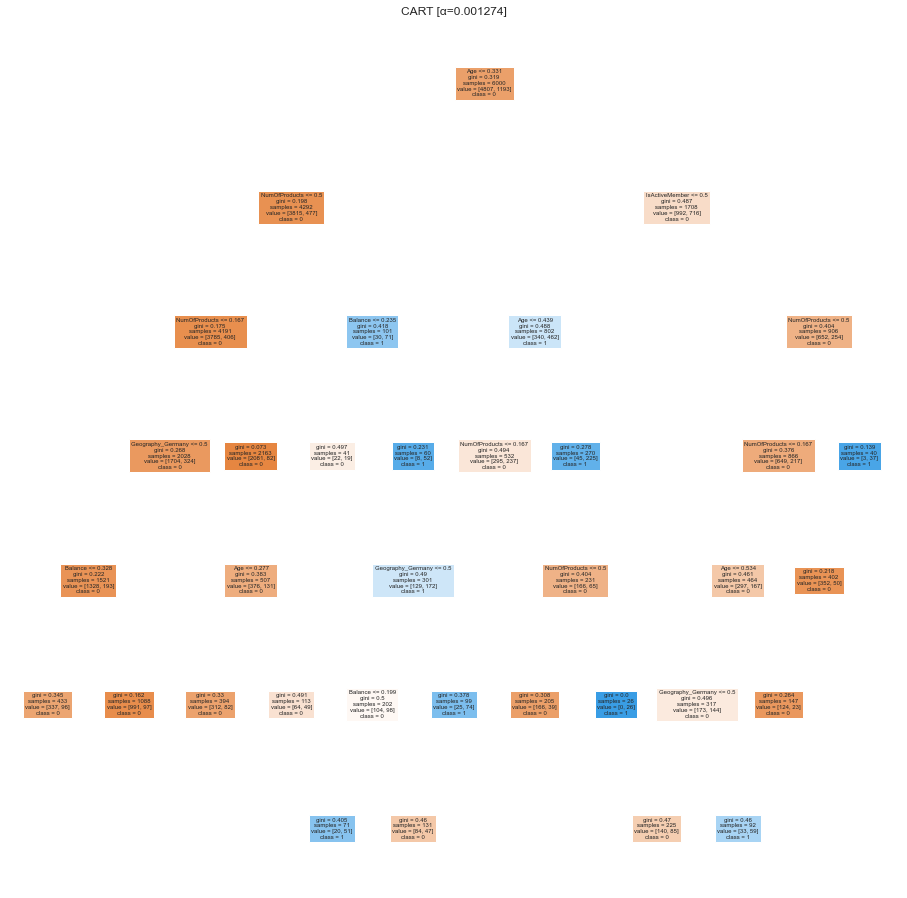

In [47]:
fig = plt.figure(figsize=(16,16))
tree.plot_tree(dtc_tree,
               feature_names=dtc_columns_x,
               class_names=["0", "1"],
               filled=True);
plt.title(dtc_title);

[CART [α=0.001274]] Optimal threshold: 0.208


array([[1271,  297],
       [ 141,  291]])

              precision    recall  f1-score   support

           0       0.90      0.81      0.85      1568
           1       0.49      0.67      0.57       432

    accuracy                           0.78      2000
   macro avg       0.70      0.74      0.71      2000
weighted avg       0.81      0.78      0.79      2000



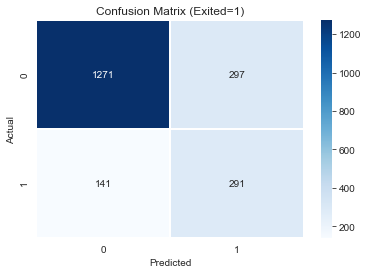

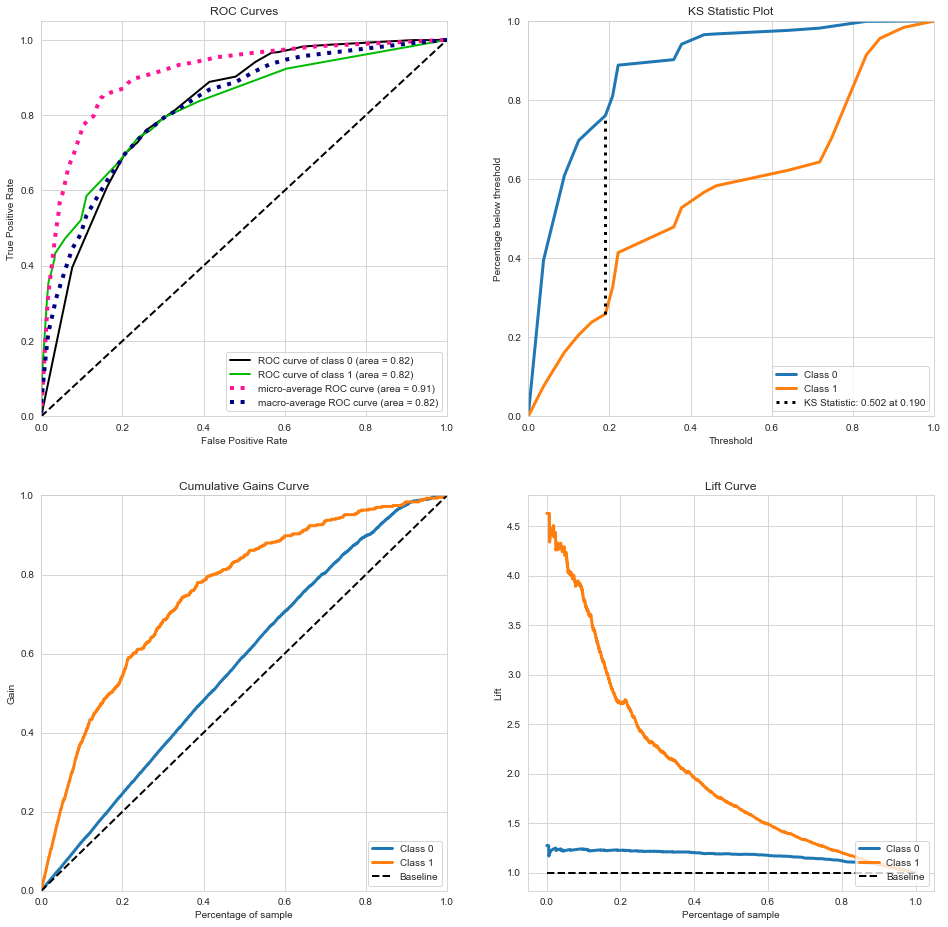

In [48]:
training_accuracy = dtc_model.score(dtc_train_x, dtc_train_y)
validation_accuracy = dtc_model.score(dtc_val_x, dtc_val_y)

summaries = create_summary(dtc_title, 
                           dtc_test_y, 
                           dtc_y_scores, 
                           training_accuracy,
                           validation_accuracy,
                           summaries);


## Neural Network (Optional) <a class="anchor" id="nn"></a>

In [49]:
def create_nn_model(parameters):
    model = Sequential()
    model.add(Dense(parameters['first_layer'],
                input_dim=nn_train_x.shape[1],
                kernel_regularizer=tf.keras.regularizers.l2(parameters['l2_regularizer']),  
                activation=parameters['activation'],
                kernel_initializer=parameters['kernel_initializer'],
                bias_initializer=parameters['bias_initializer']))
    model.add(Dropout(rate=parameters['dropout']))
    model.add(Dense(parameters['second_layer'],
                kernel_regularizer=tf.keras.regularizers.l2(parameters['l2_regularizer']), 
                activation=parameters['activation'],
                kernel_initializer=parameters['kernel_initializer'],
                bias_initializer=parameters['bias_initializer']))
    model.add(Dropout(rate=parameters['dropout']))
    model.add(Dense(1, activation='sigmoid',
                kernel_initializer=parameters['kernel_initializer'],
                bias_initializer=parameters['bias_initializer']))

    model.compile(loss = 'binary_crossentropy', 
                  optimizer=parameters['optimizer'], 
                  metrics=['accuracy'])
    return model;

### FCNN <a class="anchor" id="fcnn"></a>

In [50]:
quantile_transformer = QuantileTransformer(output_distribution='normal')
nn_columns_x = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Geography_France", "Geography_Germany", "Geography_Spain", "Gender_Male", "Gender_Female"]
nn_columns_y = ["Exited"]

nn_train_x = pd.DataFrame(quantile_transformer.fit_transform(bdt_train[nn_columns_x]), columns=nn_columns_x)
nn_train_y = bdt_train[nn_columns_y]

nn_val_x = pd.DataFrame(quantile_transformer.fit_transform(bdt_validate[nn_columns_x]), columns=nn_columns_x)
nn_val_y = bdt_validate[nn_columns_y]

nn_test_x = pd.DataFrame(quantile_transformer.fit_transform(bdt_test[nn_columns_x]), columns=nn_columns_x)
nn_test_y = bdt_test[nn_columns_y]

In [51]:
## Inputs
## 16 hidden layers (relu)
## Dropout (0.2)
## 32 hidden layers (relu)
## Dropout (0.2)
## Output - sigmoid

nn_parameters = {
    'kernel_initializer': 'glorot_uniform',
    'bias_initializer': 'zeros',
    'l2_regularizer': 0.001,
    'first_layer': 32,
    'second_layer': 64,
    'dropout': 0.2,
    'activation': 'relu',
    'optimizer': 'adam',
    'batch_size': 32,
    'epochs': 200,
    'verbosity': 0
}

In [52]:
## Neural network architecture
## https://medium.com/finc-engineering/user-churn-prediction-using-neural-network-with-keras-c48f23ef4e8b
## http://drunkendatascience.com/predicting-customer-churn-with-neural-networks-in-keras/
## - Dropouts to decrease over fitting (if necessary_)
nn_model = KerasClassifier(create_nn_model, 
                           parameters=nn_parameters,
                           batch_size=nn_parameters['batch_size'],
                           epochs=nn_parameters['epochs'], 
                           verbose=nn_parameters['verbosity']);

nn_history = nn_model.fit(nn_train_x, nn_train_y, 
                          validation_data=[nn_val_x, nn_val_y]);


In [53]:
#nn_optimizer=['rmsprop', 'sgd', 'adam']
#nn_param_grid = dict(optimizer=nn_optimizer)

#nn_grid = GridSearchCV(estimator=nn_model, 
#                       param_grid=nn_param_grid,
#                       n_jobs=-1)
#nn_grid_result = nn_grid.fit(X=nn_train_x, y=nn_train_y, callbacks=[nn_callback])
#summarize_grid_result(nn_grid_result)

**Note: This model takes ~60s to run**

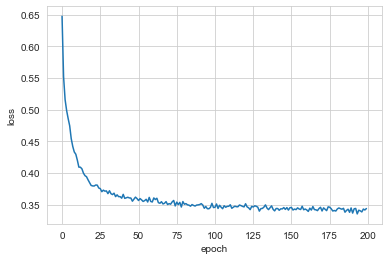

In [54]:
fig = sns.lineplot(data=nn_history.history['loss']);
fig.set(ylabel="loss", xlabel = "epoch");

[neural-network] Optimal threshold: 0.224


array([[1338,  230],
       [ 130,  302]])

              precision    recall  f1-score   support

           0       0.91      0.85      0.88      1568
           1       0.57      0.70      0.63       432

    accuracy                           0.82      2000
   macro avg       0.74      0.78      0.75      2000
weighted avg       0.84      0.82      0.83      2000



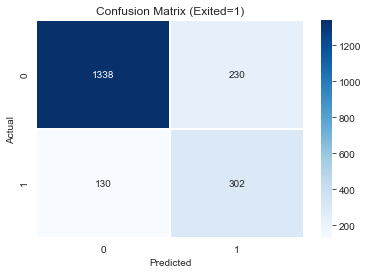

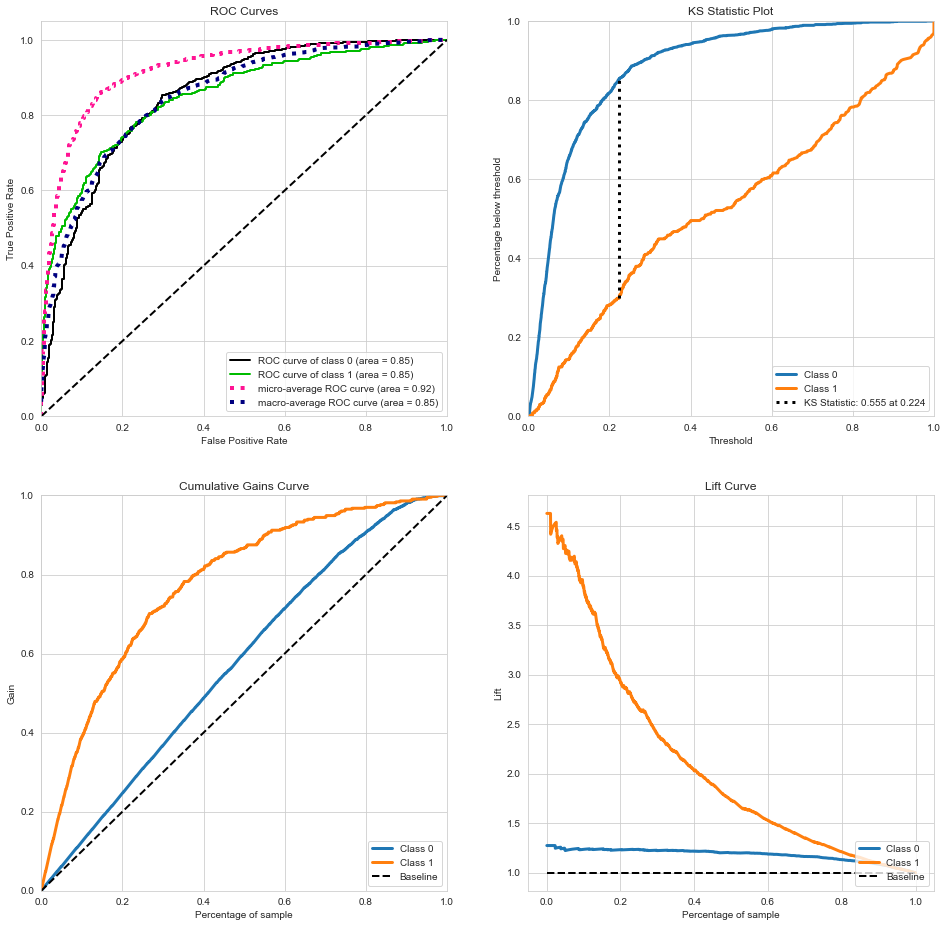

In [55]:
nn_y_scores = nn_model.predict_proba(nn_test_x);

training_accuracy = nn_model.score(nn_train_x, nn_train_y)
validation_accuracy = nn_model.score(nn_val_x, nn_val_y)

summaries = create_summary("neural-network", 
                           nn_test_y, 
                           nn_y_scores, 
                           training_accuracy,
                           validation_accuracy,
                           summaries);

### FCNN w/ SMOTE <a class="anchor" id="smote"></a>

The NN seems to good a good job of classifying class 1, but we still do not see much gain in class 0. This may be because 80% of the data is class 0, so the default position of the algorithm and dataset is just to predict 0. I am going to use the Synthetic Minority Oversampling Technique (SMOTE) to augment the minority class and see if we realize improvements.

In [56]:
# Create the SMOTE dataset
smote_train_x = nn_train_x;
smote_train_y = nn_train_y;

smote_val_x = nn_val_x;
smote_val_y = nn_val_y;

smote_test_x = nn_test_x;
smote_test_y = nn_test_y;

In [57]:
print("Before SMOTE, count (y = 1): ", np.sum(smote_train_y==1))
print("Before SMOTE, count (y = 0): ", np.sum(smote_train_y==0))

sm = SMOTE(random_state=2, k_neighbors=max_k_neighbor)
smote_train_x, smote_train_y = sm.fit_sample(smote_train_x, smote_train_y)

print("After SMOTE, count (y = 1): ", np.sum(smote_train_y==1))
print("After SMOTE, count (y = 0): ", np.sum(smote_train_y==0))

Before SMOTE, count (y = 1):  Exited    1193
dtype: int64
Before SMOTE, count (y = 0):  Exited    4807
dtype: int64
After SMOTE, count (y = 1):  Exited    4807
dtype: int64
After SMOTE, count (y = 0):  Exited    4807
dtype: int64


In [58]:
# Increase epochs
smote_parameters = nn_parameters;
smote_parameters['epochs'] = 500;

# We use the same NN above and train it w/ the smote dataset.
smote_model = KerasClassifier(create_nn_model, 
                              parameters=smote_parameters,
                              batch_size=smote_parameters['batch_size'],
                              epochs=smote_parameters['epochs'], 
                              verbose=smote_parameters['verbosity']);

smote_history = smote_model.fit(smote_train_x, smote_train_y, 
                             validation_data=[smote_val_x, smote_val_y]);



**The above model takes ~5m to train**

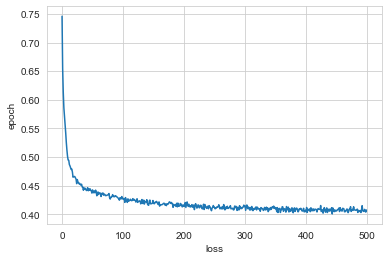

In [59]:
# Plot the loss funciton
fig = sns.lineplot(data=smote_history.history['loss']);
fig.set(xlabel="loss", ylabel = "epoch");

[nn-smote] Optimal threshold: 0.555


array([[1310,  258],
       [ 131,  301]])

              precision    recall  f1-score   support

           0       0.91      0.84      0.87      1568
           1       0.54      0.70      0.61       432

    accuracy                           0.81      2000
   macro avg       0.72      0.77      0.74      2000
weighted avg       0.83      0.81      0.81      2000



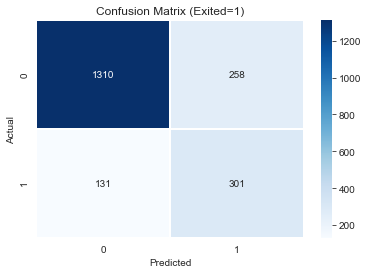

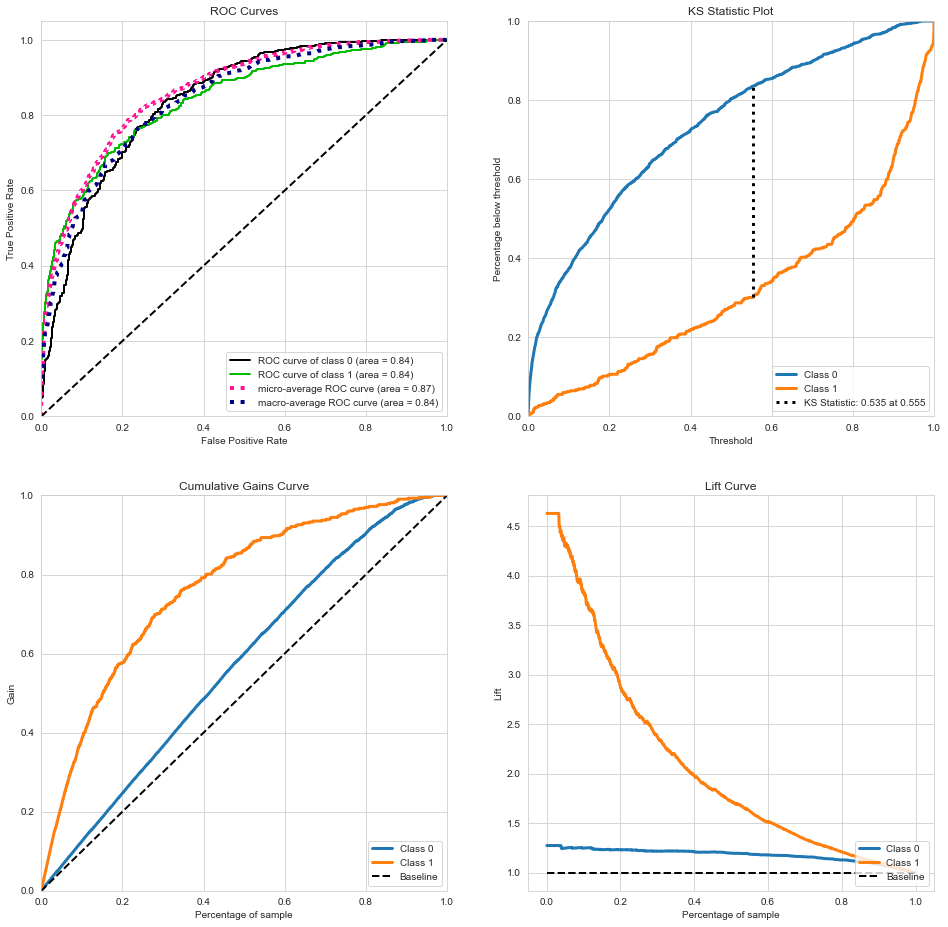

In [60]:
# Print the summary information
smote_y_scores = smote_model.predict_proba(smote_test_x);

training_accuracy = nn_model.score(smote_train_x, smote_train_y)
validation_accuracy = nn_model.score(smote_val_x, smote_val_y)

summaries = create_summary("nn-smote", 
                           smote_test_y, 
                           smote_y_scores, 
                           training_accuracy,
                           validation_accuracy,
                           summaries);

## Ensemble <a class="anchor" id="ensemble"></a>

# Model Selection <a class="anchor" id="selection"></a>

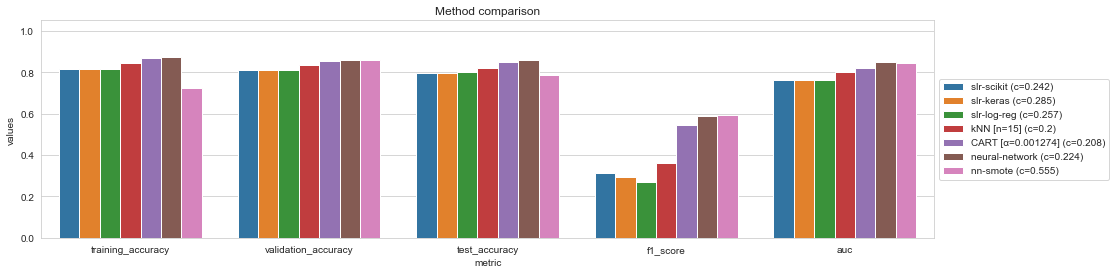

In [61]:
metrics = summaries[["method", "training_accuracy", "validation_accuracy", "test_accuracy", "f1_score", "auc"]]
reshaped_barplot = pd.melt(metrics, id_vars="method", var_name="metric", value_name="values")

plt.figure(figsize=(16,4))
sns.set_style("whitegrid")
fig = sns.barplot(data=reshaped_barplot, x="metric", y="values", hue="method");
fig.set_title("Method comparison");
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.set_ylim([0, 1.05]);

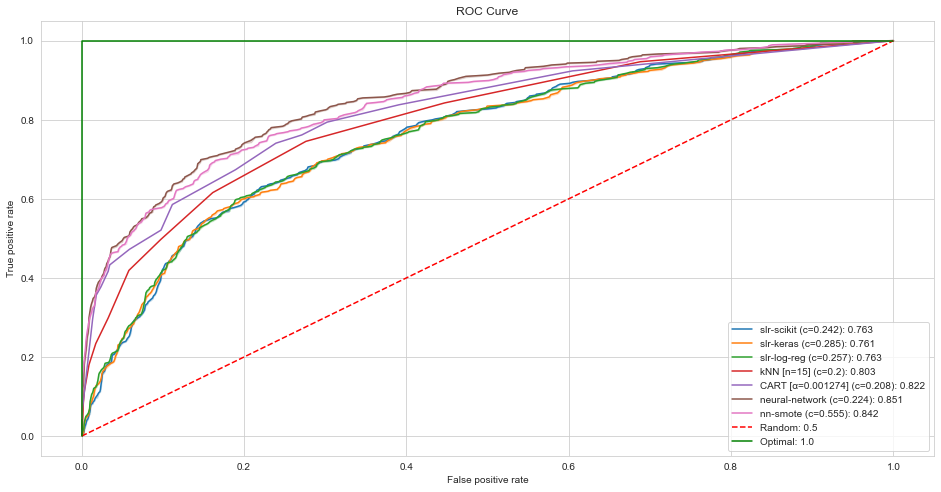

In [62]:
fig, axes = plt.subplots(1, 1, figsize=(16, 8));
 
for index, row in summaries.iterrows():
    sns.lineplot(ax=fig.axes[0], x=row["fpr"], y=row["tpr"], label = row["method"] + ": " + str(round(row["auc"], 3)))

plt.plot([0,1], [0,1], 'r--', label = 'Random: 0.5')
plt.plot([0,0,1], [0,1,1], 'g-', label = 'Optimal: 1.0')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

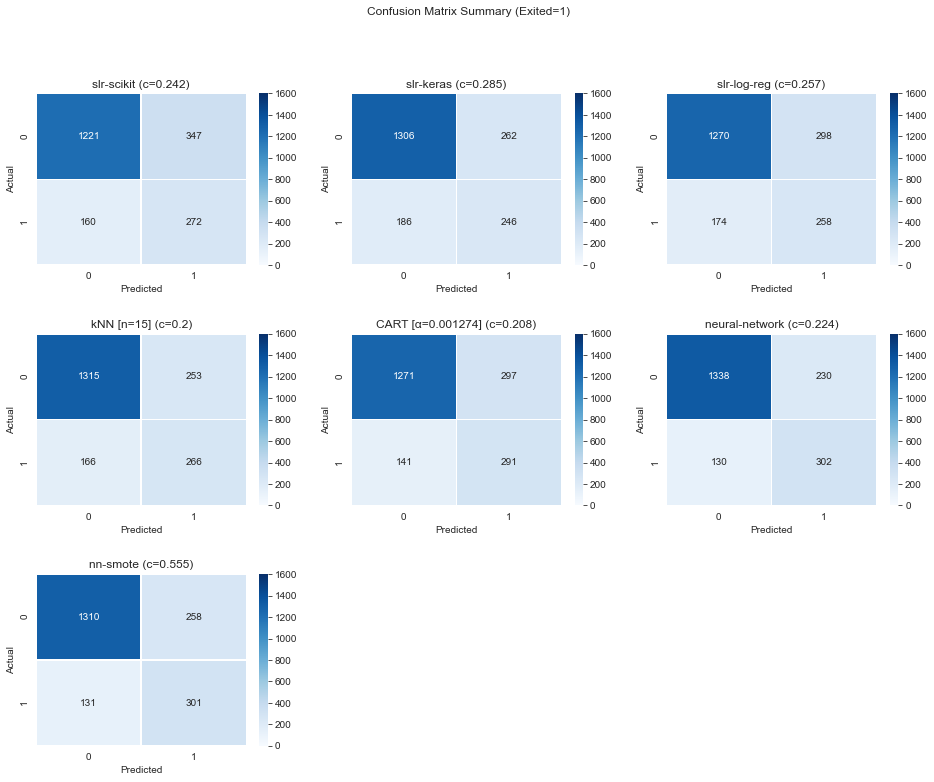

In [63]:
cnf_grid_cols = 3;
cnf_n_items = summaries.shape[0]
cnf_grid_rows = np.ceil(cnf_n_items/cnf_grid_cols).astype('int')

fig, axes = plt.subplots(cnf_grid_rows, cnf_grid_cols, figsize=(16, 4*cnf_grid_rows));

for index, row in summaries.iterrows():
    r = np.trunc(index/3).astype('int')
    c = index%cnf_grid_cols;
    sub_fig = sns.heatmap(ax=axes[r,c], data=row["cnf_matrix"], annot=True, fmt="d", linewidths=.5, cmap="Blues", vmin=0, vmax=1600);
    title = row["method"]
    sub_fig.set_title(title);
    sub_fig.set_ylabel("Actual");
    sub_fig.set_xlabel("Predicted");

# delete the unused columns
cols_to_delete = cnf_grid_cols-cnf_n_items%cnf_grid_cols
for i in range(cols_to_delete):
    fig.delaxes(axes[r][cnf_grid_cols-1-i])
    
fig.suptitle("Confusion Matrix Summary (Exited=1)");
fig.subplots_adjust(hspace=0.4)

Let us calculate the value of the above charts:

A retained customer gives us \\$100 in revenue. A lost customer means we get \\$0 in revenue from them. We spend $5 to reach out to customers who might churn. If contacted, 20% of the customers who would churn will not. (e.g. if 10 people will churn, and we contact all 10 of them, only 8 will leave). Based on this analysis, here is how much money we obtain by using each of the algorithms.

neural-network (c=0.224) has the highest revenue at $137,180


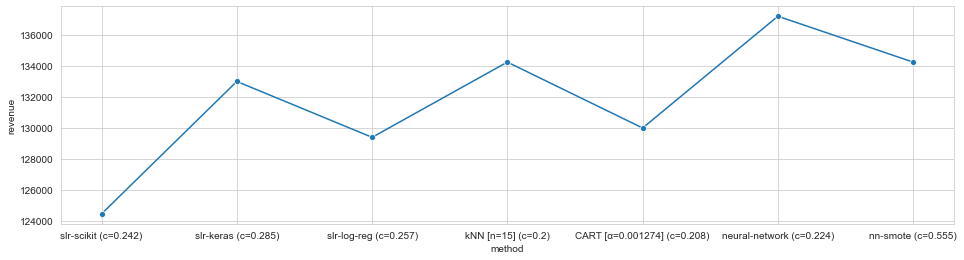

In [64]:
revenue_gain_customer = 100
revenue_lost_customer = 0
retention_rate = 0.20
cost_per_contact = 5

revenues = np.empty(summaries.shape[0])

for index, row in summaries.iterrows():
    cfm = row["cnf_matrix"]
    tp = cfm[0][0]  # Customer we keep
    fp = cfm[0][1]  # Customer will keep but reach out to anyways
    fn = cfm[1][0]  # Customer we will lose but we do not predict it so we do not reach out
    tn = cfm[1][1]  # Customers we predict will leave and we reach out
    
    customer_revenue = tp*revenue_gain_customer - fp*cost_per_contact - fn*revenue_lost_customer - tn*cost_per_contact - tn*(1-retention_rate)*revenue_lost_customer + tn*retention_rate*revenue_gain_customer
    revenues[index] = customer_revenue;
    
summaries["revenue"] = revenues;

plt.figure(figsize=(16,4));
sns.lineplot(data=summaries, x="method", y="revenue", marker="o")

max_index = summaries["revenue"].idxmax()
max_method = summaries.loc[max_index, "method"]
max_revenue = summaries.loc[max_index, "revenue"]
print(max_method + " has the highest revenue at ${:,.0f}".format(max_revenue))